# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy import stats
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

## Basic Setup

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [ ]:
plt.rcParams.update({'font.size': 13})

In [3]:
X_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_train_final.pkl")
X_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_valid_final.pkl")
X_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_test_final.pkl")

X_train_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_train.pkl")
X_valid_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_valid.pkl")
X_test_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_test.pkl")

y_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_train.pkl")
y_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_valid.pkl")
y_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_test.pkl")


In [4]:
X_train_all['date'] =  pd.to_datetime(X_train_all['date'])
X_valid_all['date'] =  pd.to_datetime(X_valid_all['date'])
X_test_all['date'] =  pd.to_datetime(X_test_all['date'])

In [5]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [6]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [7]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [9]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [10]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [12]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [13]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [14]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [15]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [16]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [17]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [18]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [19]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [20]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [21]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

# Loading the GridSearch

## Functions

In [22]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps


In [23]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    # Ensure y_pred is a tensor
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = tf.convert_to_tensor(y_pred.values)
    elif isinstance(y_pred, np.ndarray):
        y_pred = tf.convert_to_tensor(y_pred)

    # Ensure y_true is a tensor
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
    elif isinstance(y_true, np.ndarray):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

    y_pred_reshaped = tf.reshape(y_pred, (-1, 2))  # Keras Regressor flattens the values, so they need to be reshaped


    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)
    crps = crps.numpy()

    return crps


## Loading

In [24]:
base_path = Path(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Hyperparameter_Tuning_Ergebnisse")

In [25]:
file_name_grid_search = "grid_search_tuned_v2.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [26]:
grid_search = joblib.load(str(file_path_grid_search))

In [27]:
model = grid_search.best_estimator_

In [28]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [29]:
X = pd.concat([X_train, X_valid, X_test], axis=0)

In [30]:
y = pd.concat([y_train, y_valid, y_test], axis=0)

In [31]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [32]:
X.shape, y.shape

((3915, 12), (3915,))

In [33]:
my_scorer = make_scorer(crps_loss_function_wrapper, greater_is_better=False) 

In [34]:
scores = cross_val_score(model, X, y, cv=5, scoring=my_scorer)

print("Cross-validation scores: ", scores)
print("Mean score: ", scores.mean())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,458 (201.01 KB)

 Trainable params: 51,458 (201.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 218


Iteration: 219
Iteration: 220


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,458 (201.01 KB)

 Trainable params: 51,458 (201.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 221
Iteration: 222
Cross-validation scores:  [-396.36398315 -442.4692688  -388.97354126 -432.44140625 -382.56668091]
Mean score:  -408.56297607421874


In [35]:
scores = -scores 

In [36]:
print("Cross-validation scores: ", scores)

Cross-validation scores:  [396.36398315 442.4692688  388.97354126 432.44140625 382.56668091]


In [37]:
mean_score = np.mean(scores)
std_dev_score = np.std(scores)
print(f"Mean Score: {mean_score:.2f}")
print(f"Standard Deviation: {std_dev_score:.2f}")

Mean Score: 408.56
Standard Deviation: 24.20


In [38]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Mean CRPS: 315.84538516468314


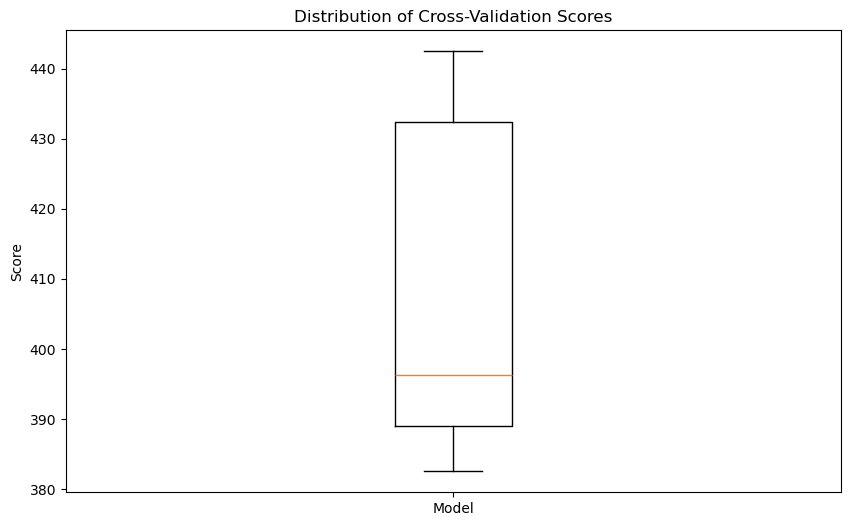

In [39]:
plt.figure(figsize=(10, 6))
plt.boxplot(scores)
plt.title('Distribution of Cross-Validation Scores')
plt.ylabel('Score')
plt.xticks([1], ['Model'])
plt.show()

In [40]:
confidence_level = 0.95
degrees_of_freedom = len(scores) - 1
t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
margin_of_error = t_value * (std_dev_score / np.sqrt(len(scores)))

print(f"95% Confidence Interval: {mean_score:.2f} ± {margin_of_error:.2f}")
print(f"({mean_score - margin_of_error:.2f}, {mean_score + margin_of_error:.2f})")

95% Confidence Interval: 408.56 ± 30.05
(378.51, 438.61)


In [41]:
previous_mean = -np.mean(grid_search.cv_results_['mean_test_score'])
previous_std = np.std(grid_search.cv_results_['mean_test_score'])
print(f"Mean Score: {mean_score:.2f}")
print(f"Standard Deviation: {std_dev_score:.2f}")

print("\nComparison with previous results:")
print(f"Current Mean ± Std: {mean_score:.2f} ± {std_dev_score:.2f}")
print(f"Previous Mean ± Std: {previous_mean:.2f} ± {previous_std:.2f}")


Mean Score: 408.56
Standard Deviation: 24.20

Comparison with previous results:
Current Mean ± Std: 408.56 ± 24.20
Previous Mean ± Std: 466.92 ± 50.64


In [42]:
-grid_search.cv_results_['mean_test_score']

array([527.81092326, 527.50664266, 531.5739034 , 532.5889384 ,
       521.11167399, 522.09142049, 527.88577271, 528.04701742,
       421.79639689, 426.71251424, 454.14241536, 442.17093913,
       408.50320435, 404.82141113, 416.96654256, 418.78400675,
       437.45043945, 436.56872559, 422.6465861 , 432.76996867,
       485.81355794, 478.12047323, 453.89053345, 458.41199748,
       525.82796224, 527.03809611, 535.87536621, 536.50613403,
       523.0592041 , 520.73297119, 529.68971761, 527.85976156,
       422.65522257, 422.73381551, 440.34291585, 435.28888957,
       411.8507487 , 418.60920207, 426.26471965, 422.41987101,
       398.88142904, 420.7979126 , 422.80169678, 396.96565755,
       416.51163737, 405.80487061, 406.78063965, 415.00098674,
       531.90408325, 532.11810303, 546.74045817, 546.89560954,
       524.06397502, 523.20621745, 531.97706095, 532.24121094,
       517.16508993, 525.73240153, 484.71343994, 489.56643677,
       419.86132812, 421.50868734, 431.92353312, 428.96

In [43]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score', ascending=True)

In [44]:
-cv_results['mean_test_score'].head()

43    396.965658
40    398.881429
69    401.298747
13    404.821411
45    405.804871
Name: mean_test_score, dtype: float64

In [45]:
-cv_results['mean_test_score'].tail()

3     532.588938
26    535.875366
27    536.506134
50    546.740458
51    546.895610
Name: mean_test_score, dtype: float64

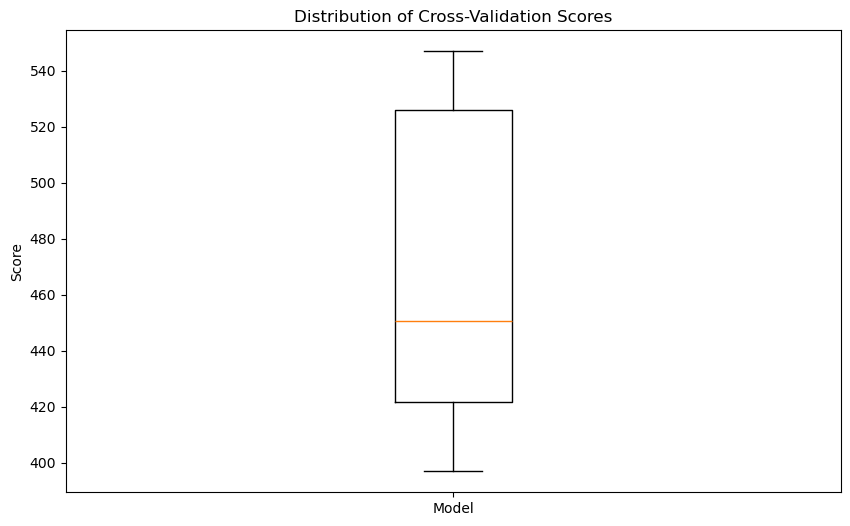

In [46]:
plt.figure(figsize=(10, 6))
plt.boxplot(-grid_search.cv_results_['mean_test_score'])
plt.title('Distribution of Cross-Validation Scores')
plt.ylabel('Score')
plt.xticks([1], ['Model'])  # Setting the x-tick label for one model
plt.show()